# Libraries

In [1]:
import sys
sys.path.append(r'C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/pytorch/pytorch-image-models')
import timm

In [2]:
timm.__version__

'0.8.1dev0'

In [3]:
import os
import sys
import shutil
import cv2
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import timm

from tqdm.notebook import tqdm
import torchmetrics

import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.metrics import f1_score,precision_score, recall_score

# Metric - Probabilistic F1

In [4]:
def probabilistic_f1(labels, predictions, beta=0.5):
    y_true_count = 0
    ctp = 0
    cfp = 0

    for idx in range(len(labels)):
        prediction = min(max(predictions[idx], 0), 1)
        if (labels[idx]):
            y_true_count += 1
            ctp += prediction
            cfp += 1 - prediction
        else:
            cfp += prediction

    beta_squared = beta * beta
    c_precision = ctp / (ctp + cfp)
    c_recall = ctp / y_true_count
    if (c_precision > 0 and c_recall > 0):
        result = (1 + beta_squared) * (c_precision * c_recall) / (beta_squared * c_precision + c_recall)
        return result
    else:
        return 0

In [5]:
TRAIN_PATH = r"C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/dataset_image_crop_512"
TEST_PATH =  r"C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/test_images"

# Dataset

In [6]:
# read raw file
df = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/5_folds_data.csv")
# add image filename columns
df["img_name"] = df["patient_id"].astype(str) + "/" + df["image_id"].astype(str) + ".png"
# shuffle it
df = df.sample(frac=1).reset_index(drop=True)

print(f"Data shape is {df.shape}") 

df.head()

Data shape is (54706, 16)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,fold,img_name
0,1,43340,653149415,R,MLO,63.0,0,0,0,0.0,0,C,49,True,0,43340/653149415.png
1,2,61715,855295333,L,MLO,58.0,0,0,0,NaN,0,NaN,48,False,1,61715/855295333.png
2,2,49601,516461022,R,MLO,67.0,0,0,0,NaN,0,NaN,29,False,2,49601/516461022.png
3,2,22589,1878824533,R,MLO,64.0,0,0,0,NaN,0,NaN,21,False,2,22589/1878824533.png
4,2,2364,1492393193,L,MLO,54.0,0,0,0,NaN,0,NaN,48,False,3,2364/1492393193.png


# Augmentation

In [7]:
transform_train = transforms.Compose([transforms.ToPILImage(),
                                      transforms.RandomVerticalFlip(),
                                      transforms.RandomEqualize(),
                                      transforms.ToTensor()])

In [8]:
transform_valid = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor()])

# Create Dataset

In [38]:
class RSNADataset(Dataset):
    def __init__(self, df, img_folder, transform=None, is_test=False):
        self.df = df
        self.img_folder = img_folder
        self.transform = transform
        self.is_test = is_test
    
    def __getitem__(self, idx):
        if self.is_test:
            dcm_path = os.path.join(self.img_folder, self.df["dcm_path"][idx])
            img = read_dicom(dcm_path)
        
            
            #print(img.shape)
        else:
            img_path = os.path.join(self.img_folder, self.df["img_name"][idx])
            img = cv2.imread(img_path,cv2.COLOR_BGR2GRAY)
        
            
            #print(img.shape)
        img = cv2.resize(img, (224, 224))
        if self.transform is not None:
            img = self.transform(img)    
        img = torch.tensor(img,dtype=torch.float32)
        #img = img.clone().detach()
        #img = img.permute(2, 1, 0)
        if not self.is_test:
            target = self.df["cancer"][idx]
            target = torch.tensor(target, dtype=torch.float32)
            return img, target
        img = img.unsqueeze(0)
        #print(img.shape)
        return img
    
    def __len__(self):
        return len(self.df)

# DataLoaders

In [39]:
ValidationFold = 0
train_df = df.query(f'fold != {ValidationFold}').reset_index(drop=True)
valid_df = df.query(f'fold == {ValidationFold}').reset_index(drop=True)

train_df.shape, valid_df.shape

((43727, 16), (10979, 16))

In [40]:
train_dataset = RSNADataset(df=train_df, img_folder=TRAIN_PATH, transform=transform_train) 
valid_dataset = RSNADataset(df=valid_df, img_folder=TRAIN_PATH, transform=transform_valid)
    
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False)

In [41]:
print(train_dataset[0][0].shape)

torch.Size([1, 224, 224])


C:\Users\Chi Nguyen\AppData\Local\Temp\ipykernel_5928\1333523824.py:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img,dtype=torch.float32)


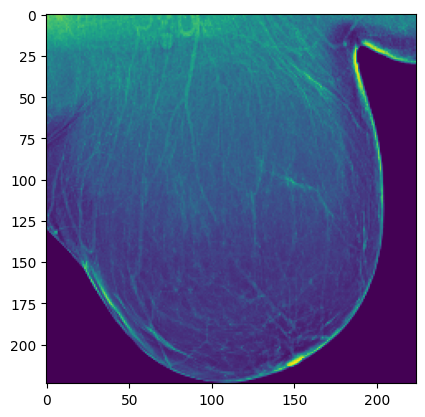

In [13]:
plt.imshow(train_dataset[0][0].permute(2, 1, 0).detach().cpu().numpy())

# Show Augmentations

In [14]:
def show_aug(inputs, targets, nrows=8, ncols=4, norm=False):
    plt.figure(figsize=(15,15 ))
    plt.subplots_adjust(wspace=0.2, hspace=1)
    i_ = 0
    
    if len(inputs) > 32:
        inputs = inputs[:25]
        
    for idx in range(len(inputs)):
    
        # normalization
        if norm:           
            img = inputs[idx].numpy().transpose(1,2,0)
            mean = [0.485, 0.456, 0.406]
            std = [0.229, 0.224, 0.225] 
            img = (img*std+mean).astype(np.float32)
            
        else:
            img = inputs[idx].numpy().astype(np.float32)
            img = img[0,:,:]
        
        plt.subplot(nrows, ncols, i_+1)
        plt.title(f"Label: {targets[idx].item()}")
        plt.imshow(img, cmap="bone"); 
        plt.axis('off')
 
        i_ += 1
        
    return plt.show()

torch.Size([16, 1, 224, 224]) torch.Size([16])


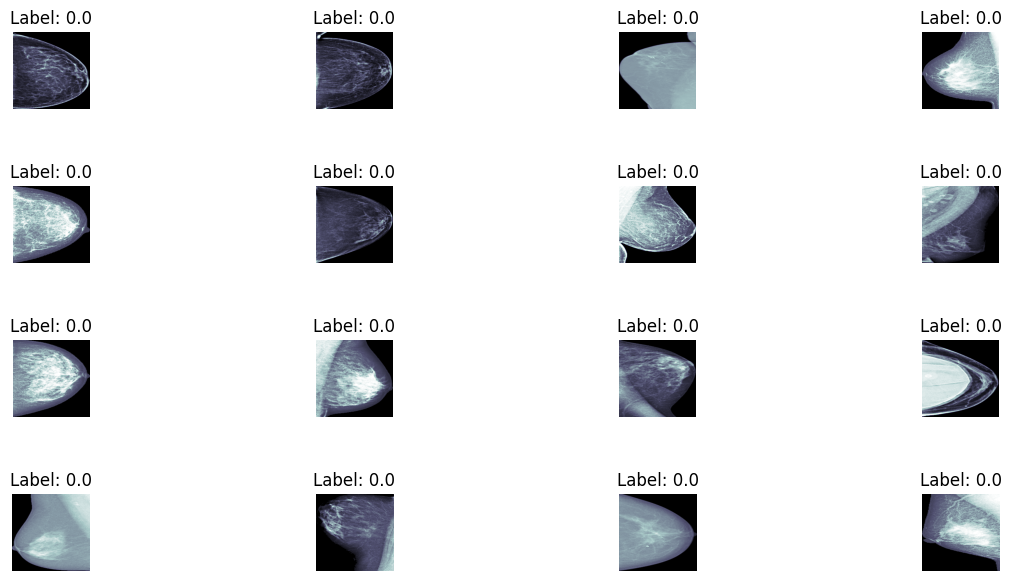

In [15]:
images, targets = next(iter(train_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

torch.Size([16, 1, 224, 224]) torch.Size([16])


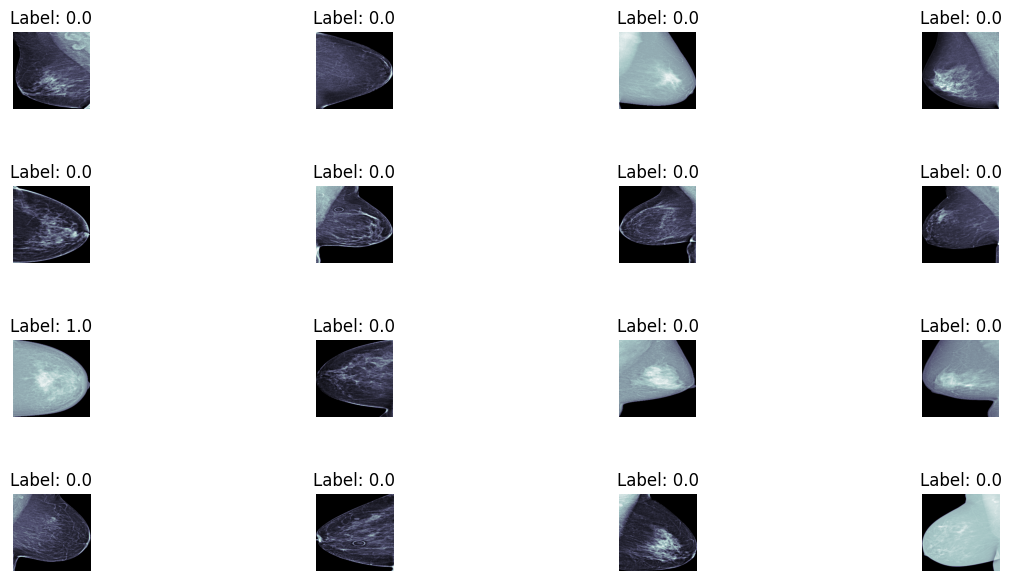

In [16]:
images, targets = next(iter(valid_loader))
print(images.shape, targets.shape)

show_aug(images, targets)

# Model

In [17]:
#!pip install torchsummary 

In [18]:
from torchsummary import summary

In [19]:
class Efficientnetv2_m(torch.nn.Module):
    def __init__(self, model_name="tf_efficientnetv2_m_in21ft1k",pretrained=True, out_dim=1):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=pretrained, in_chans=1)
        # adjust classifier
        self.backbone.classifier = nn.Linear( self.backbone.classifier.in_features, 
                             out_dim)
    def forward(self, x):
        return self.backbone(x)

In [20]:
Efficientnetv2_m()

Efficientnetv2_m(
  (backbone): EfficientNet(
    (conv_stem): Conv2dSame(1, 24, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn1): BatchNormAct2d(
      24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
      (drop): Identity()
      (act): SiLU(inplace=True)
    )
    (blocks): Sequential(
      (0): Sequential(
        (0): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
          )
          (drop_path): Identity()
        )
        (1): ConvBnAct(
          (conv): Conv2d(24, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn1): BatchNormAct2d(
            24, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
            (drop): Identity()
            (act): SiLU(inplace=True)
  

In [21]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [22]:
#effi = Efficientnetv2_m().to(device)
#summary(effi,(1,224,224))

In [23]:
n_epochs = 8

# Binary Focal Loss

In [24]:
import torch
import torch.nn.functional as F


def sigmoid_focal_loss(
    inputs: torch.Tensor,
    targets: torch.Tensor,
    alpha: float = 0.25,
    gamma: float = 2,
    reduction: str = "none",
):
    """
    Original implementation from https://github.com/facebookresearch/fvcore/blob/master/fvcore/nn/focal_loss.py .
    Loss used in RetinaNet for dense detection: https://arxiv.org/abs/1708.02002.

    Args:
        inputs: A float tensor of arbitrary shape.
                The predictions for each example.
        targets: A float tensor with the same shape as inputs. Stores the binary
                classification label for each element in inputs
                (0 for the negative class and 1 for the positive class).
        alpha: (optional) Weighting factor in range (0,1) to balance
                positive vs negative examples or -1 for ignore. Default = 0.25
        gamma: Exponent of the modulating factor (1 - p_t) to
               balance easy vs hard examples.
        reduction: 'none' | 'mean' | 'sum'
                 'none': No reduction will be applied to the output.
                 'mean': The output will be averaged.
                 'sum': The output will be summed.
    Returns:
        Loss tensor with the reduction option applied.
    """
    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    if alpha >= 0:
        alpha_t = alpha * targets + (1 - alpha) * (1 - targets)
        loss = alpha_t * loss

    if reduction == "mean":
        loss = loss.mean()
    elif reduction == "sum":
        loss = loss.sum()

    return loss

# Early Stopping

In [25]:
class EarlyStopping:
    """Early stops the training if validation loss doesn't improve after a given patience."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt', trace_func=print):
        """
        Args:
            patience (int): How long to wait after last time validation loss improved.
                            Default: 7
            verbose (bool): If True, prints a message for each validation loss improvement. 
                            Default: False
            delta (float): Minimum change in the monitored quantity to qualify as an improvement.
                            Default: 0
            path (str): Path for the checkpoint to be saved to.
                            Default: 'checkpoint.pt'
            trace_func (function): trace print function.
                            Default: print            
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        self.trace_func = trace_func
    def __call__(self, val_loss, model):
        if score < self.best_score + self.delta:
            self.counter += 1
            self.trace_func(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True

In [26]:
def fit(model, epochs, train_loader, valid_loader, optimizer,loss_fn):
    threshold = 0.5
    train_loss, val_loss = [],[]
    f1_score_hist = []
    train_precision,train_recall = [],[]
    valid_precision,valid_recall = [],[]
   
    
   
    for ep in tqdm(range(epochs+1)):
        print(f"{35*'='} Epoch:{ep+1} {35*'='}")
        model.train()
        
        running_loss = 0
        correct = 0
        total = 0
        trn_precision = 0
        trn_recall = 0
        # training
        model.train()
        for idx, (images, targets) in tqdm(enumerate(train_loader), total=len(train_loader)):
            images = images.to(device)
            targets = targets.to(device)
            
            outputs = model(images).view(-1)
            #targets = targets.unsqueeze(1)
            precision = precision_score(targets.detach().cpu().numpy(),outputs.detach().cpu().numpy()>threshold, zero_division=0)
            recall = recall_score(targets.detach().cpu().numpy(), outputs.detach().cpu().numpy()> threshold, zero_division=0)
            loss = loss_fn(outputs, targets.float())
            
                        
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            running_loss += loss.item()
            trn_precision += precision
            trn_recall += recall
            
            if idx % 1000 == 0:
                print(f"Batch: {idx} | Train Batch Loss: {loss.item():.4f}")
        
        train_loss.append(running_loss / len(train_loader))
        train_precision.append(trn_precision / len(train_loader))
        train_recall.append(trn_recall / len(train_loader))
        
        print(f"\nEpoch: {ep+1} / {epochs} | Training Loss: {np.mean(train_loss):.4f} | Precision: {np.mean(train_precision):.4f} | Recall:{np.mean(train_recall):.4f}\n")
        
        
        # validation        
        all_outputs, all_targets = [], []
        correct_t = 0
        batch_loss = 0
        total_t = 0
        val_precision = 0
        val_recall = 0
        model.eval()
        with torch.no_grad():
            
            for idx, (images_t, targets_t) in enumerate(valid_loader):
                images_t = images_t.to(device)
                targets_t = targets_t.to(device)
                
                outputs_t = model(images_t).view(-1)
                #targets_t = targets_t.unsqueeze(1)
                loss_t = loss_fn(outputs_t, targets_t.float())
                precision_t = precision_score(targets_t.detach().cpu().numpy(),outputs_t.detach().cpu().numpy()> threshold, zero_division=0)
                recall_t = recall_score(targets_t.detach().cpu().numpy(), outputs_t.detach().cpu().numpy()> threshold, zero_division=0)
                
                batch_loss += loss_t.item()
                val_precision += precision_t
                val_recall += recall_t
                
                if idx % 1000 == 0:
                    print(f"\nBatch: {idx} | Valid Batch Loss: {loss_t.item():.4f}")
                
                all_outputs.extend(torch.sigmoid(outputs_t).cpu().detach().tolist())
                all_targets.extend(targets_t.cpu().detach().tolist())
                
        prob_f1_score= probabilistic_f1(all_targets, all_outputs)
        
        f1_score_hist.append(prob_f1_score)
        val_loss.append(batch_loss/len(valid_loader))
        valid_precision.append(val_precision/ len(valid_loader))
        valid_recall.append(val_recall/len(valid_loader))
        
        
        print(f"\nEpoch: {ep+1} / {epochs} | Validation Loss: {np.mean(val_loss):.4f} | Precision: {np.mean(val_precision):.4f} |Recall {np.mean(valid_recall):.4f}\n")
        print(f"\nF1 Score for Epoch {ep+1}: {prob_f1_score:.4f}\n")
    
   
    torch.save(model.state_dict(), "C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/efficientnetv2_m.pth")
        
    return train_loss, val_loss, f1_score_hist

In [27]:
from functools import partial
def run(train_loader, val_loader, epochs=n_epochs):
    model = Efficientnetv2_m().to(device)
    
    optimizer = torch.optim.Adam(params=model.parameters(),weight_decay=1e-2,lr = 1e-5)
    #loss_fn = nn.BCEWithLogitsLoss()  
    loss_fn = partial(sigmoid_focal_loss, gamma=2.0, alpha=0.8, reduction="mean")
    #es = EarlyStopping(tolerance=5, min_delta=10)
    
    train_loss, val_loss, f1_score_hist = fit(model=model, epochs=epochs, train_loader=train_loader,
        valid_loader=val_loader, optimizer=optimizer,
       loss_fn=loss_fn)
    return train_loss, val_loss, f1_score_hist

# Train the Model

In [28]:
train_loss, val_loss, f1_score_hist = run(train_loader, valid_loader, n_epochs)

  0%|          | 0/9 [00:00<?, ?it/s]

=================================== Epoch:1 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0318
Batch: 1000 | Train Batch Loss: 0.0057
Batch: 2000 | Train Batch Loss: 0.0061

Epoch: 1 / 8 | Training Loss: 0.0184 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0307

Epoch: 1 / 8 | Validation Loss: 0.0184 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 1: 0.0248

=================================== Epoch:2 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0053
Batch: 1000 | Train Batch Loss: 0.0482
Batch: 2000 | Train Batch Loss: 0.0078

Epoch: 2 / 8 | Training Loss: 0.0178 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0402

Epoch: 2 / 8 | Validation Loss: 0.0175 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 2: 0.0263

=================================== Epoch:3 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0065
Batch: 1000 | Train Batch Loss: 0.0063
Batch: 2000 | Train Batch Loss: 0.0060

Epoch: 3 / 8 | Training Loss: 0.0175 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0334

Epoch: 3 / 8 | Validation Loss: 0.0173 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 3: 0.0254

=================================== Epoch:4 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0609
Batch: 1000 | Train Batch Loss: 0.0038
Batch: 2000 | Train Batch Loss: 0.0349

Epoch: 4 / 8 | Training Loss: 0.0173 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0444

Epoch: 4 / 8 | Validation Loss: 0.0176 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 4: 0.0251

=================================== Epoch:5 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0076
Batch: 1000 | Train Batch Loss: 0.0338
Batch: 2000 | Train Batch Loss: 0.0747

Epoch: 5 / 8 | Training Loss: 0.0172 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0480

Epoch: 5 / 8 | Validation Loss: 0.0173 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 5: 0.0258

=================================== Epoch:6 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0046
Batch: 1000 | Train Batch Loss: 0.0417
Batch: 2000 | Train Batch Loss: 0.0554

Epoch: 6 / 8 | Training Loss: 0.0171 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0348

Epoch: 6 / 8 | Validation Loss: 0.0171 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 6: 0.0255

=================================== Epoch:7 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0443
Batch: 1000 | Train Batch Loss: 0.0064
Batch: 2000 | Train Batch Loss: 0.0056

Epoch: 7 / 8 | Training Loss: 0.0170 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0411

Epoch: 7 / 8 | Validation Loss: 0.0169 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 7: 0.0258

=================================== Epoch:8 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0043
Batch: 1000 | Train Batch Loss: 0.0061
Batch: 2000 | Train Batch Loss: 0.0061

Epoch: 8 / 8 | Training Loss: 0.0169 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0297

Epoch: 8 / 8 | Validation Loss: 0.0173 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 8: 0.0261

=================================== Epoch:9 ===================================


  0%|          | 0/2733 [00:00<?, ?it/s]

Batch: 0 | Train Batch Loss: 0.0077
Batch: 1000 | Train Batch Loss: 0.0071
Batch: 2000 | Train Batch Loss: 0.0060

Epoch: 9 / 8 | Training Loss: 0.0168 | Precision: 0.0000 | Recall:0.0000


Batch: 0 | Valid Batch Loss: 0.0364

Epoch: 9 / 8 | Validation Loss: 0.0172 | Precision: 0.0000 |Recall 0.0000


F1 Score for Epoch 9: 0.0253



In [29]:
def plot_model_history(model_name,
                        train_history, val_history, 
                        num_epochs):
    
    x = np.arange(num_epochs)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(x, train_history, label='train loss', lw=1) #c="springgreen"
    plt.plot(x, val_history, label='validation loss', lw=1) #c="deeppink"

    plt.title(f"{model_name}", fontsize=15)
    plt.legend(fontsize=12)
    plt.xlabel("Epoch", fontsize=15)
    plt.ylabel("Loss", fontsize=15)

    plt.show()

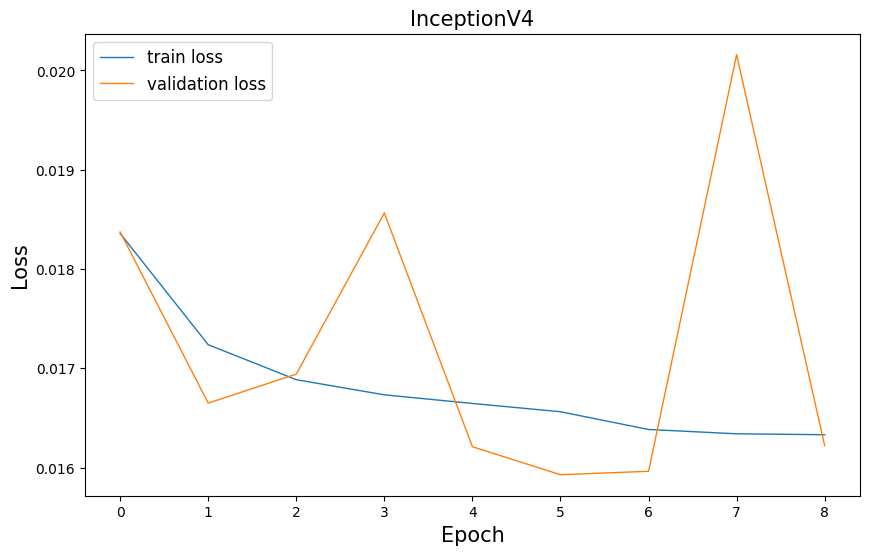

In [30]:
plot_model_history("InceptionV4", train_loss, val_loss, num_epochs=n_epochs+1)

# * predict

In [42]:
#!pip install dicomsdl
import dicomsdl

In [43]:
def read_dicom(path, fix_monochrome = True):
    dicom = dicomsdl.open(path)
    data = dicom.pixelData(storedvalue=True)  # storedvalue = True for int16 return otherwise float32
    data = data - np.min(data)
    data = data / np.max(data)
    if fix_monochrome and dicom.PhotometricInterpretation == "MONOCHROME1":
        data = 1.0 - data
    return data

In [44]:
df_test = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/test.csv")
df_test["img_name"] = df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".png"
df_test["dcm_path"] = df_test["patient_id"].astype(str) + "/" + df_test["image_id"].astype(str) + ".dcm"

df_test.head()

,site_id,patient_id,image_id,laterality,view,age,implant,machine_id,prediction_id,img_name,dcm_path
0,2,10008,736471439,L,MLO,81,0,21,10008_L,10008/736471439.png,10008/736471439.dcm
1,2,10008,1591370361,L,CC,81,0,21,10008_L,10008/1591370361.png,10008/1591370361.dcm
2,2,10008,68070693,R,MLO,81,0,21,10008_R,10008/68070693.png,10008/68070693.dcm
3,2,10008,361203119,R,CC,81,0,21,10008_R,10008/361203119.png,10008/361203119.dcm


In [45]:
test_dataset= RSNADataset(df=df_test, img_folder=TEST_PATH, transform=None, is_test=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [46]:
#plt.imshow(next(iter(test_loader))[0][0], cmap="bone")

In [47]:
for i in next(iter(test_loader)):
    print(i.shape)

torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])
torch.Size([1, 224, 224])


In [48]:
def prediction_model(model, test_loader):    
    model.eval()
    
    with torch.no_grad():
        preds = []
        if len(test_loader) != 1:
            # there are images and targets in loader in batches
            for images, targets in tqdm(test_loader, total=len(test_loader)):
                for im in tqdm(images):
                    pred = model(im.unsqueeze(0).float())
                    preds.append(pred)
        else:
            # just images
            for batch in tqdm(test_loader, total=len(test_loader)):
                for im in tqdm(batch):
                    pred = model(im.unsqueeze(0).float())
                    preds.append(pred)
            
        return torch.cat(preds).numpy()

In [50]:
preds = prediction_model(Efficientnetv2_m(), test_loader)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?it/s]

In [51]:
preds

array([[-0.46321693],
       [ 0.05170374],
       [-0.08810242],
       [-0.06838579]], dtype=float32)

In [52]:
def logistic_id(x):
    return (1/(1+np.exp(-x)))

In [53]:
scaled_preds = logistic_id(preds) 

In [54]:
scaled_preds

array([[0.38622296],
       [0.51292306],
       [0.4779886 ],
       [0.48291022]], dtype=float32)

In [55]:
sub_df = pd.read_csv("C:/Users/Chi Nguyen/Desktop/breast-cancer-detection/sample_submission.csv")
sub_df.head()

,prediction_id,cancer
0,10008_L,0.021168
1,10008_R,0.021168


In [56]:
prediction_id = df_test['patient_id'].astype(str) + "_" + df_test['laterality']
prediction_id

0    10008_L
1    10008_L
2    10008_R
3    10008_R
dtype: object

In [57]:
data = {"prediction_id": np.array(list((prediction_id))),
        "cancer": scaled_preds.T[0]
}

sub_df = pd.DataFrame(data=data)

In [58]:
sub_df

,prediction_id,cancer
0,10008_L,0.386223
1,10008_L,0.512923
2,10008_R,0.477989
3,10008_R,0.482910


In [59]:
subb = sub_df.groupby('prediction_id')[['cancer']].median()
subb

,cancer
prediction_id,
10008_L,0.449573
10008_R,0.480449


In [60]:
subb.to_csv('submission.csv',index = True)